# PyQt5 컬러피커

* 난이도 : ★★★★☆☆☆☆☆☆
* 필요라이브러리: PyQt5
* 윈도우 전용 프로그램 입니다.
* 리눅스나 맥에서 사용하려면 해당 OS 에 맞는 캡쳐 함수를 직접 구현하거나 라이브러리를 사용해야 합니다.


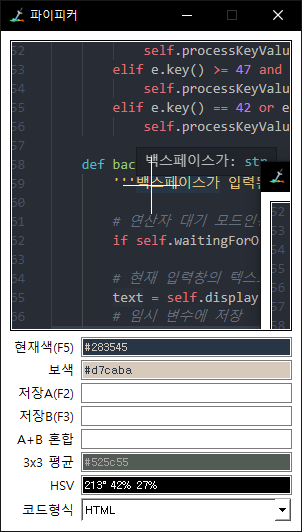

In [ ]:
'''
윈도우용 칼라 피커

타 운영체제에서는 captureWindow 를 새로 구현해야합니다.
python 캡쳐 라이브러리들이 있긴 하지만 칼라피커 프로그램 특성상 
고속으로 캡쳐를 할 수 없어 사용이 용이하지 않습니다.
직접 gcc 용 프로그램으로 개발을 해야할듯....
'''
from pynput import keyboard

import win32gui
import win32ui
import win32con
import time

import colorsys
from PIL import Image
import cv2
import numpy as np

from PyQt5 import QtCore
from PyQt5 import QtWidgets
from PyQt5 import QtGui

LABEL_LIST = ["현재색(F5)", "보색", "저장A(F2)", "저장B(F3)", "A+B 혼합", "3x3 평균", "HSV"]


def captureWindow(x=0, y=0, width=0, height=0):
    '''윈도우 캡쳐 함수
    win32 api 로 직접 DC를 캡쳐해야 마우스 이동 속도만큼의 속도로 캡쳐가 가능합니다.
    이 함수에서 사용한 함수들은 실제 win32 api 에서 사용하는 함수들이고
    프로그래밍 로직 역시 파이썬에서 쓰긴 했지만 win32 프로그래밍 방식의 로직이니 참고만 하시길 바랍니다. 
    
    Args:
        x (int) : 캡쳐 시작 x 좌표
        y (int) : 캡쳐 시작 y 좌표
        width (int) : 캡쳐할 width 영역
        height (int) : 캡쳐할 height 영역
    
    Returns:
        numpy.ndarray : openCV 이미지 (RGB)
    '''
    # 데스크탑 윈도우는 윈도우 최상의 바탕화면 윈도우의 핸들을 구합니다.
    # 핸들은 윈도우에서 생성되는 모든 객체에 할당되는 32비트 정수형 인덱스 값 입니다.
    hwin = win32gui.GetDesktopWindow()

    # 핸들에 해당하는 Device Context 의 핸들을 구합니다.
    # DC는 화면 출력에 관한 모든 정보를 담고 있는 구조체 입니다.
    # 이 구조체는 윈도우 GDI 모듈에 의해 사용됩니다.
    # 여기서 hwindc 는 실제 바탕화면의 디바이스 핸들이며 (DC가 아님!!) 직접 사용하지 않습니다.
    hwindc = win32gui.GetWindowDC(hwin)

    # 위에서 구한 바탕화면 DC 핸들로 부터 실제 DC를 생성합니다.
    # 여기서 srcdc가 실제 바탕화면의 dc 라고 보면 됩니다.
    # srcdc에 무언가 그리면 실제 윈도우 바탕화면에 그려집니다. (주의!!!)
    srcdc = win32ui.CreateDCFromHandle(hwindc)

    # 위에서 복제한 바탕화면 DC와 호환 가능한 DC를 또 생성합니다.
    # 그냥 쉽게 복제 했다고 보면 됩니다.
    # 여기서 생성된 memdc 가 최종 캡쳐에 사용할 DC 가 됩니다.
    memdc = srcdc.CreateCompatibleDC()

    # DC는 Device Context 객체기 때문에 여기에 그림을 그리거나 하려면 도화지 같은게 필요합니다.
    # 윈도우에서 도화지는 비트맵 객체를 사용합니다. 
    # 그림을 그리고 글씨를 쓰는 그런 그래픽작업은 DC를 이용하지만 실제 그림이 그려지는곳은 비트맵입니다.
    bmp = win32ui.CreateBitmap()

    # 생성된 비트맵 객체를 바탕화면 dc와 호환가능하게 설정합니다.
    # 이때 비트맵의 가로, 세로를 설정합니다.
    bmp.CreateCompatibleBitmap(srcdc, width, height)

    # 바탕화면 DC에서 호환가능하게 복제된 memdc에 비트맵 도화지를 장착합니다.
    memdc.SelectObject(bmp)

    # 바탕화면 DC 인 srcdc로 부터 memdc로 비트맵을 SRCCOPY 합니다.
    # BitBlt 함수는 비트맵을 전송하는 함수인데 인자값은
    # ((복제될 시작 위치), (복제할 크기), 원본DC, (원본DC의 복제시작 위치))
    # 참조링크 : https://docs.microsoft.com/en-us/windows/desktop/api/wingdi/nf-wingdi-bitblt
    memdc.BitBlt((0, 0), (width, height), srcdc, (x, y), win32con.SRCCOPY)

    # 복제된 비트맵 객체에서 비트맵 데이터만 추출
    signedIntsArray = bmp.GetBitmapBits(True)

    # 추출된 비트맵 데이터를 numpy 배열로 변환
    img = np.fromstring(signedIntsArray, dtype='uint8')

    # 넘파일 배열의 shape를 설정해줍니다.
    # 여기서 4채널은 배경화면 복제시 RGBA 로 Alpha 값이 포함되었기 때문입니다.
    img.shape = (height,width,4)

    # 지금까지 사용한 자원을 모두 반환하고 Release 합니다.
    # 이걸 안하고 계속 DC 를 사용하면 윈도우 화면이 깨지거나 할 수 있습니다.
    srcdc.DeleteDC()
    memdc.DeleteDC()
    win32gui.ReleaseDC(hwin, hwindc)
    win32gui.DeleteObject(bmp.GetHandle())

    # opencv 이미지를 RGB로 컨버트 해서 리턴함
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

class MyPicker(QtWidgets.QMainWindow):
    '''PyQt 프로그램 본체 클래스'''

    def __init__(self):
        '''생성자'''

        # 상속받은 QtWidgets.QMainWindow 의 부모 생성자를 호출합니다.
        super().__init__()

        # 일시정지 상태 변수
        self.pause = False
        # 줌 레벨 변수 +, - 누르면 이 값이 변함
        self.zoom = 1

        # 현재 마우스 포인터의 BGR 값 (RGB 가 아님!!!!!!)
        self.currentBGR = ()

        # 색상 A, B 를 저장할 변수, 혼합 기능을 사용하기 위해서 필요
        self.saveBGR = [(-1, -1, -1), (-1, -1, -1)]

        # 윈도우 타이틀바
        self.title = '파이피커'
        self.setWindowTitle(self.title)

        # 윈도우 사이즈
        self.setFixedSize(300, 500)

        # 윈도우 시작시 모니터 가운데서 실행하게
        self.centerOnScreen()

        # 프로그램 아이콘 설정
        self.setWindowIcon(QtGui.QIcon('icon.png'))

        # 윈도우 내의 최상위위젯 생성
        self.main_widget = QtWidgets.QWidget()

        # 프로그램에 필요한 위젯들 생성
        self.create_widgets()

        # QMainWindow 사용시 setCentralWidget 을 하지 않으면 위젯 배치가 엉망이 됨
        self.setCentralWidget(self.main_widget)
        
        # 메인 윈도우 배경색상 설정
        self.setStyleSheet("background-color:#FFFFFF")
        #self.setWindowFlags(Qt.FramelessWindowHint)

        # 마우스의 포인터 위치를 항상 알아야 하기 때문에
        # 이부분을 쓰레드로 분리해야 합니다.
        self.worker = Worker()               # 백그라운드에서 돌아갈 인스턴스 소환

        # PyQt 에서 쓰레드간 통신을 하기 위해선 시그널, 슬롯 개념이 필요합니다.
        self.worker.sig_update.connect(self.updateWindow)

        # 쓰레드 시작
        self.worker.start()

        # 메인 윈도우 show
        self.show()
    
    def keyPressEvent(self, e):
        '''오버라이딩 된 키 감지 함수

        Args:
            e (object) : 키 감지 정보가 넘어옴
        '''

        if e.key() == QtCore.Qt.Key_F2:
            self.saveBGR[0] = self.currentBGR
            print(self.currentBGR)
            print(self.saveBGR)
        elif e.key() == QtCore.Qt.Key_F3:
            self.saveBGR[1] = self.currentBGR
        elif e.key() == QtCore.Qt.Key_F4:
            pass
        elif e.key() == QtCore.Qt.Key_F5:
            self.pause = not self.pause
        elif e.key() == QtCore.Qt.Key_Plus:
            self.zoom += 1
        elif e.key() == QtCore.Qt.Key_Minus:
            self.zoom -= 1
            if self.zoom < 1: self.zoom = 1

    def centerOnScreen(self):
        '''메인 윈도우를 화면 중앙에 띄우는 함수'''

        # 바탕화면 해상도를 구합니다.
        resolution = QtWidgets.QDesktopWidget().screenGeometry()

        # (바탕화면 해상도 / 2) - (윈도우 크기 / 2) = 중앙
        self.move((resolution.width() / 2) - (self.frameSize().width() / 2),
                  (resolution.height() / 2) - (self.frameSize().height() / 2)) 

    def create_widgets(self):
        '''메인 윈도우에 출력될 각종 위젯들 생성'''

        # QLineEdit 과 QLabel 에서 사용할 스타일시트
        self.editStyle = "padding:1px; font-size:13px;font-family:맑은 고딕;border:1px solid #000000"
        self.labelStyle = "padding:1px; font-size:13px;font-family:맑은 고딕;"

        # 세로 레이아웃 생성
        vbox_layout = QtWidgets.QVBoxLayout()

        # 캡쳐된 이미지가 출력될 QLabel 생성
        self.viewer = QtWidgets.QLabel()
        # 사이즈는 300, 300
        self.viewer.setBaseSize(300, 300)
        self.viewer.setText("이미지 보기창")
        self.viewer.setAlignment(QtCore.Qt.AlignCenter|QtCore.Qt.AlignVCenter)
        # 스타일 적용
        self.viewer.setStyleSheet(self.editStyle)

        # 세로 레이아웃에 추가
        vbox_layout.addWidget(self.viewer)

        # 나머지 라벨 및 색정보 값을 출력할 Grid 레이아웃 생성
        grid = QtWidgets.QGridLayout()
        
        # 그리드에 셀간 공백 추가
        grid.setSpacing(3)

        # 라벨은 그냥 "현재색상, 보색... " 등 그냥 라벨
        self.labels = []

        # colors 는 QLineEdit 인데 실제 색상값과 배경 색상을 변경해줘야함
        self.colors = []

        # LABEL_LIST 만큼 QLabel 과 QLineEdit 생성 및 설정
        for i, l in enumerate(LABEL_LIST):
            label = QtWidgets.QLabel(l)
            label.setStyleSheet(self.labelStyle)
            label.setAlignment(QtCore.Qt.AlignRight | QtCore.Qt.AlignVCenter)

            color =  QtWidgets.QLineEdit()
            color.setStyleSheet(self.editStyle)
            color.setReadOnly(True)

            # 그리드 AddWidget() 시 1부터 시작
            grid.addWidget(label, i+1, 0)
            grid.addWidget(color, i+1, 1)

            self.labels.append(label)
            self.colors.append(color)

        label = QtWidgets.QLabel("코드형식")
        label.setStyleSheet(self.labelStyle)
        label.setAlignment(QtCore.Qt.AlignRight | QtCore.Qt.AlignVCenter)

        self.comboBox = QtWidgets.QComboBox()
        self.comboBox.addItem("HTML")
        self.comboBox.addItem("RGB")
        self.comboBox.setStyleSheet("padding:3px;")
        grid.addWidget(label, len(LABEL_LIST) + 1, 0)
        grid.addWidget(self.comboBox, len(LABEL_LIST) + 1, 1)

        # 세로 레이아웃에 그리드 레이아웃 추가
        vbox_layout.addLayout(grid)

        # 메인 레이아웃에 세로 레이아웃 설정
        self.main_widget.setLayout(vbox_layout)

    
    def get_code(self, bgr):
        '''bgr 값을 컨트롤에 출력하기 위해 값을 설정해주는 함수

        Args:
            bgr (tuple) : BGR 값

        Returns:
            tuple (텍스트, 텍스트 색상, 배경 색상)
        '''

        # 해당 bgr 의 보색을 구합니다.
        inverse = self.get_inverse_color(bgr)

        # 현재 출력 모드가 어떤건지 확인
        current_text = self.comboBox.currentText()

        out_text = ""

        # 출력모드가 HTML 인경우
        if current_text == "HTML":
            # bgr 값을 HTML 형식으로 포맷팅
            out_text = "#%02x%02x%02x" %(bgr[2], bgr[1], bgr[0])
        elif current_text == "RGB":
            # bgr 값을 RGB 형식으로 포맷팅
            out_text = "{},{},{}".format(bgr[2], bgr[1], bgr[0])

        # 배경색은 bgr 값을 출력합니다. 
        bg_color = "#%02x%02x%02x" %(bgr[2], bgr[1], bgr[0])
        # 해당 BGR 색상값의 보색값을 구합니다.
        # 이 보색값이 위젯의 텍스트색이 되야 글자가 보입니다.
        text_color = "#%02x%02x%02x" %(inverse[2], inverse[1], inverse[0])

        return (out_text, text_color, bg_color)

    def get_inverse_color(self, bgr):
        '''bgr 값의 보색을 구합니다.

        Args:
            bgr (tuple) : bgr 색상 값

        Returns:
            tuple (~bgr) : bgr 보색값
        '''

        # ~ 는 (Binary NOT) : bit 단위로 not 연산을 하여 보수를 구합니다.
        return (abs(255-bgr[0]), abs(255-bgr[1]), abs(255-bgr[2]))

    def resize(self, image, width=None, height=None, inter=cv2.INTER_AREA):
        '''image 를 리사이즈 하는 함수

        Args:
            image (numpay.ndarray) : opencv 이미지
            width (int) : 리사이즈 될 width 값
            height (int) : 리사이즈 될 height 값
            inter (int) : 보간법
        
        Returns:
            numpay.ndarray : 리사이즈 된 opencv 이미지
        '''

        # width 와 height 값이 둘다 없으면 그냥 None 리턴
        if width is None and height is None:
            return None

        # 최종 리사이즈될 (new_width, new_height) 튜플 변수
        dim = None

        # 원본 이미지의 h, w 
        (h, w) = image.shape[:2]

        # height 값을 기준으로 확대할때
        if width is None:
            # ratio = 높이 / 원본 이미지 높이
            # 그러면 높이가 얼마나(ratio) 크게 확대되는지를 알 수 있습니다.
            r = height / float(h)

            # 높이가 크게 확대된 만큼 폭도 확대 계산하여 dim 에 튜플형태로 저장
            dim = (int(w * r), height)
        else:
            r = width / float(w)
            dim = (width, int(h * r))

        # 실제 리사이즈
        resized = cv2.resize(image, dim, interpolation=inter)

        return resized

    @QtCore.pyqtSlot(tuple)
    def updateWindow(self, pt):
        '''QThread 함수쪽에서 보낸 시그널을 받아서 처리할 슬롯 함수, 보냄(시그널) => 받음(슬롯)
        이 함수에서 이미지를 그리고 계산하고 대부분의 기능을 처리합니다.

        Args:
            pt (tuple) : QThread 에서 보낸 현재 마우스 좌표
        '''

        # 튜플로 넘어온 인자를 x, y 로 분리
        x, y = pt

        # 일시정지 상태면 그냥 리턴
        if self.pause:
            return True

        # 현재 이미지를 출력할 QLabel 위젯의 width, height을 구합니다.
        # 여기서 고정값을 안쓰고 이렇게 직접 구해서 사용하는 이유는
        # 만약 윈도우가 리사이즈 되는 기능이 있다면 이 QLabel의 크기가 계속 바뀔 수 있기 때문에
        # QLabel 크기 만큼 이미지를 캡쳐할 수 있게 하기 위해서 입니다.
        width = self.viewer.width()
        height = self.viewer.height()

        # QLabel 의 중앙 값을 구해놓습니다.
        center_x = int(width / 2)
        center_y = int(height / 2)

        # 실제 캡쳐 시작위치는 마우스 포인터 중앙에서 
        # (캡쳐될 영역 / 2) 를 뺀 만큼이어야 합니다.
        x -= center_x
        y -= center_y

        # 윈도우 화면의 최상단인 경우에는 음수가 나올 수 있습니다.
        if x < 0: x = 0
        if y < 0: y = 0

        # 윈도우 캡쳐
        capture = captureWindow(x=x, y=y, width=width, height=height)

        # 줌 상태
        if self.zoom > 1:
            # 줌 상태인경우 이미지를 줌 레벨 만큼 확대 합니다.
            zoom_image = self.resize(capture, width=self.zoom * capture.shape[1])

            # 확대가 성공적이면
            if zoom_image is not None:
                # 확대된 이미지의 중앙값을 새로 구합니다.
                center = (int(zoom_image.shape[0]/2), int(zoom_image.shape[1]/2))
                # 이미지 크롭 [y1:y2, x1:x2]
                capture = zoom_image[center[0]-center_y:center[0]+center_y, center[1]-center_x:center[1]+center_x]

        display = []

        # 캡쳐 함수가 RGB 로 리턴을 했기 때문에 다시 BGR로 변환 합니다.
        capture = cv2.cvtColor(capture,cv2.COLOR_RGB2BGR)

        # 캡쳐된 이미지 중앙의 1 픽셀을 구합니다.
        bgr = capture[center_y, center_x]

        # currentBGR 변수에 저장해놓습니다.
        self.currentBGR = (bgr[0], bgr[1], bgr[2])
        
        # 현재 캡쳐된 중앙의 픽셀값으로 hsv 값을 구합니다.
        # colorsys.rgb_to_hsv 함수의 인자는 1.0 을 기준으로 하기에 255 값으로 나누기 합니다.
        hsv = colorsys.rgb_to_hsv(bgr[2]/255, bgr[1]/255, bgr[0]/255)

        # 포토샵에서 처럼 각도와 백분율로 표기하게 합니다.
        hsv_angle = (int(hsv[0] * 360), int(hsv[1] * 100), int(hsv[2] * 100))

        # 현재 마우스 포인터의 픽셀 값의 보색을 구합니다.
        bgr_inverse = self.get_inverse_color(bgr)

        # 출력을 위한 현재 색상의 코드 값을 구합니다.
        out_code, text_color, bg_color = self.get_code(bgr)

        # 보색의 코드값을 구합니다.
        out_inverse, text_color_inverse, bg_color_inverse = self.get_code(bgr_inverse)

        # hsv 값을 문자열로 포맷팅 합니다.
        out_hsv = "{}° {}% {}%".format(hsv_angle[0], hsv_angle[1], hsv_angle[2])

        # 3x3 평균값은 마우스 포인터의 중앙값에서 좌-1 부터 좌+1, 상-1 부터 상+1 가지 9칸의 값을 더해 다시 9로 나눕니다.
        aR = aG = aB = 0
        for i in range(center_y - 1, center_y + 2):
            for j in range(center_x - 1, center_x + 2):
                p = capture[i, j]
                aR += p[2]
                aG += p[1]
                aB += p[0]
        aR = abs(int(aR / 9))
        aG = abs(int(aG / 9))
        aB = abs(int(aB / 9))

        out_3x3, text_color_3x3, bg_color_3x3 = self.get_code((aB, aG, aR))

        
        out_save1 = out_save2 = out_mix = ""
        text_color_save1 = text_color_save2 = text_color_mix = "#000000"
        bg_color_save1 = bg_color_save2 = bg_color_mix = "#FFFFFF"

        # 저장된 색상값A 가 있으면
        if self.saveBGR[0][0] >= 0:
            out_save1, text_color_save1, bg_color_save1 = self.get_code(self.saveBGR[0])

        # 저장된 색상값B 가 있으면
        if self.saveBGR[1][0] >= 0:
            out_save2, text_color_save2, bg_color_save2 = self.get_code(self.saveBGR[1])
        
        # 저장된 색상값A, B 둘 다 있으면
        if self.saveBGR[0][0] >= 0 and self.saveBGR[1][0] >= 0:
            nR = self.saveBGR[0][2] + (int((self.saveBGR[1][2] - self.saveBGR[0][2]) / 2) * 1)
            nG = self.saveBGR[0][1] + (int((self.saveBGR[1][1] - self.saveBGR[0][1]) / 2) * 1)
            nB = self.saveBGR[0][0] + (int((self.saveBGR[1][0] - self.saveBGR[0][0]) / 2) * 1)
            out_mix, text_color_mix, bg_color_mix = self.get_code((nB, nG, nR))

        # 출력될 텍스트, 색상값을 배열에 추가
        display.append((out_code, text_color, bg_color))
        display.append((out_inverse, text_color_inverse, bg_color_inverse))
        display.append((out_save1, text_color_save1, bg_color_save1))
        display.append((out_save2, text_color_save2, bg_color_save2))
        display.append((out_mix, text_color_mix, bg_color_mix))
        display.append((out_3x3, text_color_3x3, bg_color_3x3))
        display.append((out_hsv, "#FFFFFF", "#000000"))
        
        # LABEL_LIST = ["현재색(F6)", "보색", "저장A(F2)", "저장B(F3)", "A+B 혼합(F4)", "3x3 평균(F5)", "HSV"]

        # 추가된 배열 값들을 실제 위젯에 적용합니다.
        for i, c in enumerate(self.colors):
            text, text_color, bgcolor = display[i]
            style = "background-color:" + bgcolor + "; color:" + text_color
            c.setText(text)
            c.setStyleSheet(style)

        # 현재 캡쳐된 이미지에 하얀색 십자가 를 그립니다.
        step = int(width / 10)
        cv2.line(capture, (center_x - step, center_y), (center_x + step, center_y), (255,255,255), 1)
        cv2.line(capture, (center_x, center_y - step), (center_x, center_y + step), (255,255,255), 1)

        # 최종 이미지를 출력하기 위해 RGB로 다시 변경
        capture = cv2.cvtColor(capture,cv2.COLOR_BGR2RGB)
        # PyQt에서 출력가능하게 opencv -> QImage로 변경
        qImg = QtGui.QImage(capture.data, width, height, 3 * width, QtGui.QImage.Format_RGB888)
        pixmap01 = QtGui.QPixmap.fromImage(qImg)

        # 이미지 출력
        self.viewer.setPixmap(pixmap01)

        
class Worker(QtCore.QThread):
    '''PyQt에서 사용할 쓰레드 클래스'''

    # 쓰레드에서 본체 프로그램쪽으로 무언가 신호를 보낼 시그널
    sig_update = QtCore.pyqtSignal(tuple)

    def __init__(self, parent=None):
        super(Worker, self).__init__(parent)

    def run(self):
        '''run 함수는 오버라이딩 된 함수 입니다.'''

        # 무한루프
        while True:
            # 현재 윈도우의 마우스 커서 위치를 구합니다.
            pt = win32gui.GetCursorPos()

            # 본체 프로그램쪽으로 시그널을 전송합니다.
            self.sig_update.emit(pt)

            # 0.05 초 딜레이
            time.sleep(0.05)


if __name__ == "__main__":
    import sys

    app = QtWidgets.QApplication(sys.argv)
    picker = MyPicker()
    sys.exit(app.exec_())
